# Hyperparameter Optimization

Tune Ridge alphas and RNN architecture for numerical prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
%matplotlib inline

In [2]:
# Feature sets
lin_feats = ['activity', 'appCat.communication', 'appCat.utilities', 'call', 'circumplex.valence', 'mood', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
rnn_feats = ['appCat.communication', 'screen', 'appCat.builtin', 'appCat.finance', 'appCat.unknown', 'mood']

In [ ]:
# Load data
df = pd.read_pickle('df_feat.pkl')
X_lin = df[lin_feats]
X_rnn = df[rnn_feats]
y = df['nextday']
# Train/test split for both
X_train_lin, X_test_lin, y_train, y_test = train_test_split(X_lin, y, test_size=0.2, random_state=42)
X_train_rnn, X_test_rnn, _, _ = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

## Ridge Regression Tuning
Use GridSearchCV to find the best alpha.

In [4]:
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_lin, y_train)
print('Best alpha:', grid.best_params_['ridge__alpha'])
print('CV MSE:', -grid.best_score_)
pred = grid.predict(X_test_lin)
print('Test MSE:', mean_squared_error(y_test, pred))

Best alpha: 10
CV MSE: 0.42823247842190293
Test MSE: 0.511728507978285


## RNN Architecture Tuning
Manual grid search over number of units and dropout.

In [5]:
# Prepare RNN data
X_tr = X_train_rnn.values.reshape(len(X_train_rnn), 1, len(rnn_feats))
X_te = X_test_rnn.values.reshape(len(X_test_rnn), 1, len(rnn_feats))
results = []
for units in [10, 50, 100, 500]:
    for dr in [0.01, 0.1, 0.3]:
        model = Sequential()
        model.add(SimpleRNN(units, input_shape=(1, len(rnn_feats)), activation='tanh'))
        model.add(Dropout(dr))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_tr, y_train, epochs=20, batch_size=32, verbose=0)
        mse = model.evaluate(X_te, y_test, verbose=0)
        results.append({'units': units, 'dropout': dr, 'mse': mse})
results_df = pd.DataFrame(results)
display(results_df.sort_values('mse').head())

,units,dropout,mse
10,500,0.10,0.711567
11,500,0.30,0.712241
9,500,0.01,0.721411
8,100,0.30,0.806473
6,100,0.01,0.831800


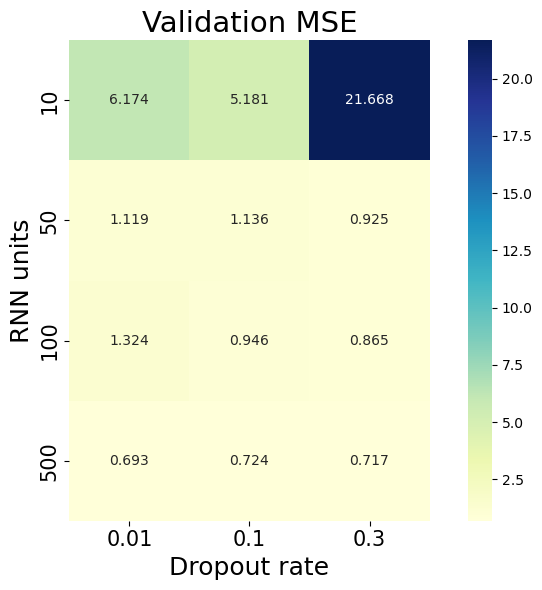

In [35]:
import seaborn as sns

# Pivot MSEs into a matrix
heat = results_df.pivot(index='units', columns='dropout', values='mse')

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(heat, annot=True, fmt='.3f',cmap='YlGnBu', square=True,)
plt.xlabel('Dropout rate', fontsize=12 * scale)
plt.ylabel('RNN units', fontsize=12 * scale)
plt.title('Validation MSE', fontsize=14 * scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.tight_layout()
plt.savefig('rnn_mse_heatmap.pdf', dpi=300)
plt.show()

In [ ]:
# Load data
df = pd.read_pickle('df_feat.pkl')
X = df[lin_feats]
y = df['nextday']
# Train/test split for both
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Example: X_train, y_train, X_test, y_test should be defined earlier in your notebook

# Define the parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# 1. Ridge Regression with MAE
ridge_mae = Ridge()
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
grid_mae = GridSearchCV(ridge_mae, param_grid, scoring=mae_scorer, cv=5)
grid_mae.fit(X_train, y_train)

print("Best parameters (MAE):", grid_mae.best_params_)
print("Best MAE score:", -grid_mae.best_score_)  # Negative because greater_is_better=False

# 2. Ridge Regression with MSE
ridge_mse = Ridge()
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_mse = GridSearchCV(ridge_mse, param_grid, scoring=mse_scorer, cv=5)
grid_mse.fit(X_train, y_train)

print("Best parameters (MSE):", grid_mse.best_params_)
print("Best MSE score:", -grid_mse.best_score_)  # Negative because greater_is_better=False

# If you want to evaluate on test set:
y_pred_mae = grid_mae.predict(X_test)
y_pred_mse = grid_mse.predict(X_test)
print("Test MAE (best MAE model):", mean_absolute_error(y_test, y_pred_mae))
print("Test MSE (best MSE model):", mean_squared_error(y_test, y_pred_mse))

Best parameters (MAE): {'alpha': 10}
Best MAE score: 0.4825671549035581
Best parameters (MSE): {'alpha': 1}
Best MSE score: 0.42880897161989895
Test MAE (best MAE model): 0.528783175243807
Test MSE (best MSE model): 0.5163306995967081


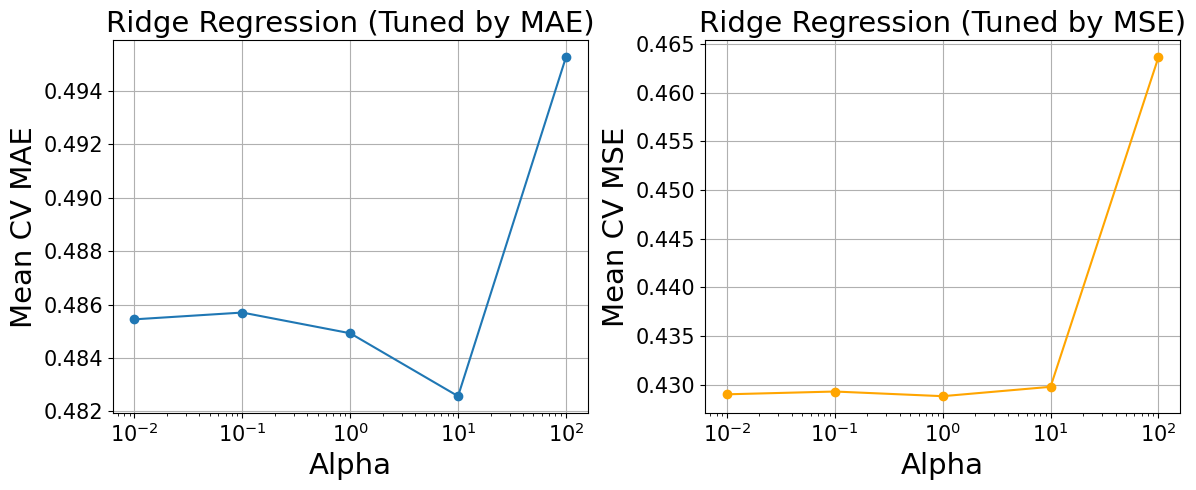

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve mean test scores for each alpha (negated to get positive MAE/MSE)
alphas = param_grid['alpha']
mean_mae_scores = -grid_mae.cv_results_['mean_test_score']
mean_mse_scores = -grid_mse.cv_results_['mean_test_score']

plt.figure(figsize=(12, 5))


scale = 1.5
# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(alphas, mean_mae_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize=14 * scale)
plt.ylabel('Mean CV MAE', fontsize=14* scale)
plt.title('Ridge Regression (Tuned by MAE)', fontsize=14* scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.grid(True)

# Plot for MSE
plt.subplot(1, 2, 2)
plt.plot(alphas, mean_mse_scores, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Alpha', fontsize=14 * scale)
plt.ylabel('Mean CV MSE', fontsize=14* scale)
plt.title('Ridge Regression (Tuned by MSE)', fontsize=14* scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.grid(True)

plt.tight_layout()
plt.savefig('ridge_parameter_optimization.pdf', dpi=300)
plt.show()

5/5 [==============================] - 0s 2ms/step


,units,dropout,mse,mae
11,500,0.30,0.717420,0.636647
9,500,0.01,0.692581,0.641449
10,500,0.10,0.724310,0.665001
5,50,0.30,0.925367,0.719206
8,100,0.30,0.864553,0.726520


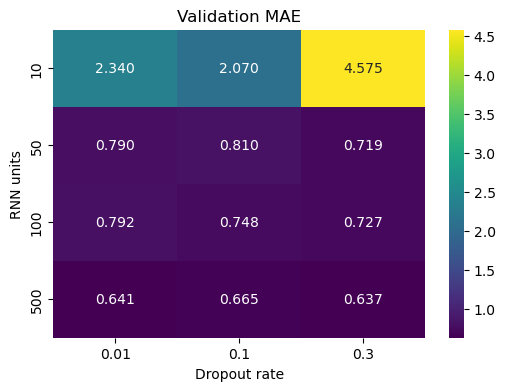

In [27]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare RNN data
X_tr = X_train_rnn.values.reshape(len(X_train_rnn), 1, len(rnn_feats))
X_te = X_test_rnn.values.reshape(len(X_test_rnn), 1, len(rnn_feats))
results = []

for units in [10, 50, 100, 500]:
    for dr in [0.01, 0.1, 0.3]:
        model = Sequential()
        model.add(SimpleRNN(units, input_shape=(1, len(rnn_feats)), activation='tanh'))
        model.add(Dropout(dr))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_tr, y_train, epochs=20, batch_size=32, verbose=0)
        # Get predictions
        y_pred = model.predict(X_te).flatten()
        # Calculate MAE and MSE
        mse = model.evaluate(X_te, y_test, verbose=0)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'units': units, 'dropout': dr, 'mse': mse, 'mae': mae})

results_df = pd.DataFrame(results)
display(results_df.sort_values('mae').head())

# Pivot MAEs into a matrix
heat_mae = results_df.pivot(index='units', columns='dropout', values='mae')

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(heat_mae, annot=True, fmt='.3f', cmap='viridis')
plt.xlabel('Dropout rate')
plt.ylabel('RNN units')
plt.title('Validation MAE')
plt.show()

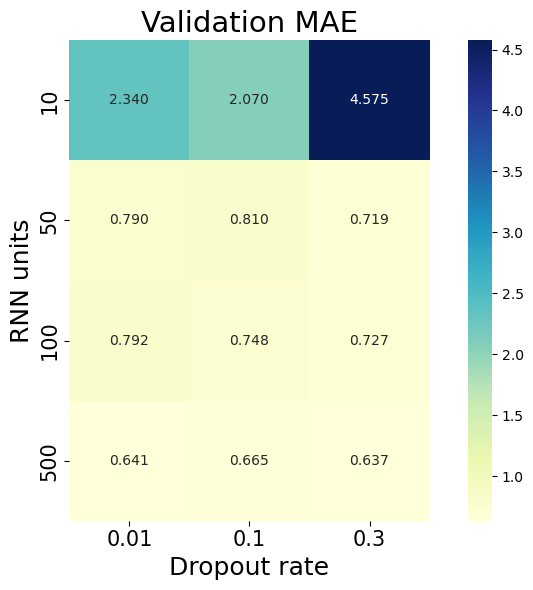

In [33]:
scale = 1.5

plt.figure(figsize=(8,6))
sns.heatmap(heat_mae, annot=True, fmt='.3f', cmap='YlGnBu', square=True,
)
plt.xlabel('Dropout rate', fontsize=12 * scale)
plt.ylabel('RNN units', fontsize=12 * scale)
plt.title('Validation MAE', fontsize=14 * scale)
plt.xticks(fontsize=10 * scale)
plt.yticks(fontsize=10 * scale)
plt.tight_layout()
plt.savefig('rnn_mae_heatmap.pdf', dpi=300)
plt.show()